In [1]:
using Oceananigans

using Oceananigans.Units: minute, minutes, hour

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA C:\Users\shiva\.julia\packages\CUDA\DL5Zo\src\initialization.jl:42


In [2]:
using Random
using Printf
using Plots
using JLD2


$\int\Sigma_{x=5}^{3}$

In [3]:
Nz=24
Lz=32

refinement=1.2
stretching=12

h(k)=(k-1)/Nz                          #Height of n_th cell
ζ₀(k) = 1 + (h(k) - 1) / refinement
Σ(k) = (1 - exp(-stretching * h(k))) / (1 - exp(-stretching))
z_faces(k) = Lz * (ζ₀(k) * Σ(k) - 1)
grid = RectilinearGrid(size = (32, 32, Nz),
                          x = (0, 64),
                          y = (0, 64),
                          z = z_faces)

RectilinearGrid{Float64, Periodic, Periodic, Bounded}
             architecture: CPU()
                   domain: x ∈ [0.0, 64.0], y ∈ [0.0, 64.0], z ∈ [-32.0, 0.0]
                 topology: (Periodic, Periodic, Bounded)
        size (Nx, Ny, Nz): (32, 32, 24)
        halo (Hx, Hy, Hz): (1, 1, 1)
             spacing in x: Regular, with spacing 2.0
             spacing in y: Regular, with spacing 2.0
             spacing in z: Stretched, with spacing min=1.111234, max=2.535707

In [4]:
plot(grid.Δzᵃᵃᶜ[1:Nz]

LoadError: syntax: incomplete: premature end of input

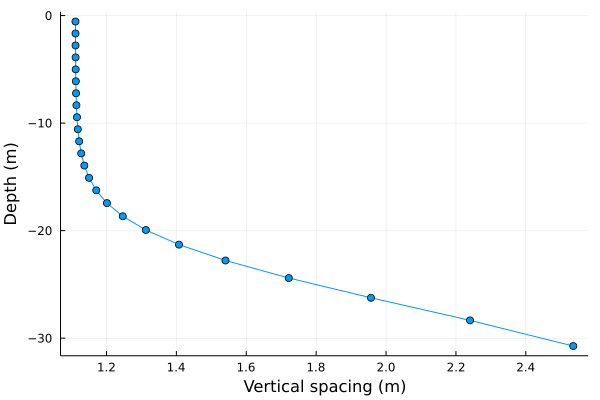

In [5]:
plot(grid.Δzᵃᵃᶜ[1:Nz], grid.zᵃᵃᶜ[1:Nz],
     marker = :circle,
     ylabel = "Depth (m)",
     xlabel = "Vertical spacing (m)",
     legend = nothing)

In [6]:
buoyancy = SeawaterBuoyancy(equation_of_state=LinearEquationOfState(α=2e-4, β=8e-4))

SeawaterBuoyancy{Float64}: g = 9.80665
└── equation of state: LinearEquationOfState{Float64}: α = 2.00e-04, β = 8.00e-04

In [7]:
Qʰ = 200  
ρₒ = 1026
cᴾ = 3991

Qᵀ = Qʰ / (ρₒ * cᴾ) 

4.884283985946938e-5

In [8]:
dTdz = 0.01 

T_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵀ),
                                bottom = GradientBoundaryCondition(dTdz))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Float64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

In [9]:
u₁₀ = 10    # m s⁻¹, average wind velocity 10 meters above the ocean
cᴰ = 2.5e-3 # dimensionless drag coefficient
ρₐ = 1.225  # kg m⁻³, average density of air at sea-level

Qᵘ = - ρₐ / ρₒ * cᴰ * u₁₀ * abs(u₁₀) # m² s⁻²

-0.0002984892787524367

In [10]:
u_bcs = FieldBoundaryConditions(top = FluxBoundaryCondition(Qᵘ))

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Float64}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

In [11]:
@inline Qˢ(x, y, t, S, evaporation_rate) = - evaporation_rate * S # [salinity unit] m s⁻¹

Qˢ (generic function with 1 method)

In [12]:
evaporation_rate = 1e-3 / hour # m s⁻¹

2.7777777777777776e-7

In [13]:
evaporation_bc = FluxBoundaryCondition(Qˢ, field_dependencies=:S, parameters=evaporation_rate)

BoundaryCondition: classification=Flux, condition=Qˢ(x, y, t, S, evaporation_rate) in Main at In[11]:1

In [14]:
S_bcs = FieldBoundaryConditions(top=evaporation_bc)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Oceananigans.BoundaryConditions.ContinuousBoundaryFunction{Nothing, Nothing, Nothing, Nothing, typeof(Qˢ), Float64, Tuple{Symbol}, Nothing, Nothing}}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

In [15]:
model = NonhydrostaticModel(
                            advection = UpwindBiasedFifthOrder(),
                            timestepper = :RungeKutta3,
                            grid = grid,
                            tracers = (:T, :S),
                            coriolis = FPlane(f=1e-4),
                            buoyancy = buoyancy,
                            closure = AnisotropicMinimumDissipation(),
                            boundary_conditions = (u=u_bcs, T=T_bcs, S=S_bcs))

┌ Warning: Inflating model grid halo size to (3, 3, 3) and recreating grid. The model grid will be different from the input grid. To avoid this warning, pass halo=(3, 3, 3) when constructing the grid.
└ @ Oceananigans.Models.NonhydrostaticModels C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Models\NonhydrostaticModels\nonhydrostatic_model.jl:130


NonhydrostaticModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RectilinearGrid{Float64, Periodic, Periodic, Bounded}(Nx=32, Ny=32, Nz=24)
├── tracers: (:T, :S)
├── closure: AnisotropicMinimumDissipation{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:T, :S), Tuple{Float64, Float64}}, Float64, NamedTuple{(:T, :S), Tuple{Float64, Float64}}, Nothing}
├── buoyancy: SeawaterBuoyancy{Float64, LinearEquationOfState{Float64}, Nothing, Nothing}
└── coriolis: FPlane{Float64}

In [16]:
# Random noise damped at top and bottom
Ξ(z) = randn() * z / model.grid.Lz * (1 + z / model.grid.Lz) # noise

# Temperature initial condition: a stable density gradient with random noise superposed.
Tᵢ(x, y, z) = 20 + dTdz * z + dTdz * model.grid.Lz * 1e-6 * Ξ(z)

# Velocity initial condition: random noise scaled by the friction velocity.
uᵢ(x, y, z) = sqrt(abs(Qᵘ)) * 1e-3 * Ξ(z)

# `set!` the `model` fields using functions or constants:
set!(model, u=uᵢ, w=uᵢ, T=Tᵢ, S=35)

In [17]:
simulation = Simulation(model, Δt=10.0, stop_time=40minutes)

Simulation{typename(NonhydrostaticModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0
├── Next time step: 10 seconds
├── Elapsed wall time: 0 seconds
├── Stop time: 40 minutes
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: typename(OrderedCollections.OrderedDict) with 4 entries:
│   ├── stop_time_exceeded => typename(Callback)
│   ├── stop_iteration_exceeded => typename(Callback)
│   ├── wall_time_limit_exceeded => typename(Callback)
│   └── nan_checker => typename(Callback)
├── Output writers: typename(OrderedCollections.OrderedDict) with no entries
└── Diagnostics: typename(OrderedCollections.OrderedDict) with no entries

In [18]:
wizard = TimeStepWizard(cfl=1.0, max_change=1.1, max_Δt=1minute)

simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(10))

Callback{TimeStepWizard{Float64, typeof(Oceananigans.Utils.cell_advection_timescale), typeof(Oceananigans.Simulations.infinite_diffusion_timescale)}, IterationInterval}(TimeStepWizard{Float64, typeof(Oceananigans.Utils.cell_advection_timescale), typeof(Oceananigans.Simulations.infinite_diffusion_timescale)}(1.0, Inf, 1.1, 0.5, 60.0, 0.0, Oceananigans.Utils.cell_advection_timescale, Oceananigans.Simulations.infinite_diffusion_timescale), IterationInterval(10))

In [19]:
# Print a progress message
progress_message(sim) = @printf("Iteration: %04d, time: %s, Δt: %s, max(|w|) = %.1e ms⁻¹, wall time: %s\n",
                                iteration(sim),
                                prettytime(sim),
                                prettytime(sim.Δt),
                                maximum(abs, sim.model.velocities.w),
                                prettytime(sim.run_wall_time))

simulation.callbacks[:progress] = Callback(progress_message, IterationInterval(10))

Callback{typeof(progress_message), IterationInterval}(progress_message, IterationInterval(10))

In [20]:
# Create a NamedTuple with eddy viscosity
eddy_viscosity = (; νₑ = model.diffusivity_fields.νₑ)

simulation.output_writers[:slices] =
    JLD2OutputWriter(model, merge(model.velocities, model.tracers, eddy_viscosity),
                           prefix = "ocean_wind_mixing_and_convection",
                     field_slicer = FieldSlicer(j=Int(grid.Ny/2)),
                         schedule = TimeInterval(1minute),
                            force = true)

┌ Warning: Cannot serialize timeseries/S/serialized/boundary_conditions as it contains functions. Will replace with missing. Function boundary conditions must be restored manually.
└ @ Oceananigans.OutputWriters C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\OutputWriters\output_writer_utils.jl:65


JLD2OutputWriter scheduled on TimeInterval(1 minute):
├── filepath: .\ocean_wind_mixing_and_convection.jld2
├── 6 outputs: (:u, :v, :w, :T, :S, :νₑ)
├── field slicer: FieldSlicer(:, 16, :, with_halos=false)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [21]:
run!(simulation)

Iteration: 0000, time: 0 seconds, Δt: 11 seconds, max(|w|) = 1.0e-05 ms⁻¹, wall time: 0 seconds
Iteration: 0010, time: 1.733 minutes, Δt: 12.100 seconds, max(|w|) = 9.7e-06 ms⁻¹, wall time: 2.173 minutes
Iteration: 0020, time: 3.403 minutes, Δt: 13.310 seconds, max(|w|) = 8.8e-06 ms⁻¹, wall time: 2.187 minutes
Iteration: 0030, time: 5.444 minutes, Δt: 14.641 seconds, max(|w|) = 7.7e-06 ms⁻¹, wall time: 2.200 minutes
Iteration: 0040, time: 7.488 minutes, Δt: 16.105 seconds, max(|w|) = 6.6e-06 ms⁻¹, wall time: 2.211 minutes
Iteration: 0050, time: 10 minutes, Δt: 12.417 seconds, max(|w|) = 7.7e-06 ms⁻¹, wall time: 2.227 minutes
Iteration: 0060, time: 12 minutes, Δt: 10.350 seconds, max(|w|) = 8.6e-06 ms⁻¹, wall time: 2.245 minutes
Iteration: 0070, time: 13.690 minutes, Δt: 9.074 seconds, max(|w|) = 1.7e-05 ms⁻¹, wall time: 2.258 minutes
Iteration: 0080, time: 15 minutes, Δt: 8.281 seconds, max(|w|) = 4.6e-05 ms⁻¹, wall time: 2.269 minutes
Iteration: 0090, time: 16.276 minutes, Δt: 7.628 s

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:168
┌ Info:     ... simulation initialization complete (10.189 seconds)
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:190
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:113
┌ Info:     ... initial time step complete (1.986 minutes).
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:120
┌ Info: Simulation is stopping. Model time 40 minutes has hit or exceeded simulation stop time 40 minutes.
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\simulation.jl:164


In [22]:
# Coordinate arrays
xw, yw, zw = nodes(model.velocities.w)
xT, yT, zT = nodes(model.tracers.T)

# Open the file with our data
file = jldopen(simulation.output_writers[:slices].filepath)

# Extract a vector of iterations
iterations = parse.(Int, keys(file["timeseries/t"]))

""" Returns colorbar levels equispaced between `(-clim, clim)` and encompassing the extrema of `c`. """
function divergent_levels(c, clim, nlevels=21)
    cmax = maximum(abs, c)
    levels = clim > cmax ? range(-clim, stop=clim, length=nlevels) : range(-cmax, stop=cmax, length=nlevels)
    return (levels[1], levels[end]), levels
end

""" Returns colorbar levels equispaced between `clims` and encompassing the extrema of `c`."""
function sequential_levels(c, clims, nlevels=20)
    levels = range(clims[1], stop=clims[2], length=nlevels)
    cmin, cmax = minimum(c), maximum(c)
    cmin < clims[1] && (levels = vcat([cmin], levels))
    cmax > clims[2] && (levels = vcat(levels, [cmax]))
    return clims, levels
end

sequential_levels

In [46]:
times = [file["timeseries/t/$iter"] for iter in iterations]
intro = searchsortedfirst(times, 10minutes)

anim = @animate for (i, iter) in enumerate(iterations[intro:end])

    @info "Drawing frame $i from iteration $iter..."
    
    t = file["timeseries/t/$iter"]
    w = file["timeseries/w/$iter"][:,1,:]
    T = file["timeseries/T/$iter"][:, 1, :]
    S = file["timeseries/S/$iter"][:, 1, :]
    νₑ = file["timeseries/νₑ/$iter"][:, 1, :]
#     @info size(w)
    wlims, wlevels = divergent_levels(w, 2e-2)
    Tlims, Tlevels = sequential_levels(T, (19.7, 19.99))
    Slims, Slevels = sequential_levels(S, (35, 35.005))
    νlims, νlevels = sequential_levels(νₑ, (1e-6, 5e-3))

    kwargs = (linewidth=0, xlabel="x (m)", ylabel="z (m)", aspectratio=1,
              xlims=(0, grid.Lx), ylims=(-grid.Lz, 0))

    w_plot = contourf(xw, yw, w'; color=:balance, clims=wlims, levels=wlevels, kwargs...)
    T_plot = contourf(xT, zT, T'; color=:thermal, clims=Tlims, levels=Tlevels, kwargs...)
    S_plot = contourf(xT, zT, S'; color=:haline,  clims=Slims, levels=Slevels, kwargs...)

    # We use a heatmap for the eddy viscosity to observe how it varies on the grid scale.
    ν_plot = heatmap(xT, zT, νₑ'; color=:thermal, clims=νlims, levels=νlevels, kwargs...)

    w_title = @sprintf("vertical velocity (m s⁻¹), t = %s", prettytime(t))
    T_title = "temperature (ᵒC)"
    S_title = "salinity (g kg⁻¹)"
    ν_title = "eddy viscosity (m² s⁻¹)"

    # Arrange the plots side-by-side.
    plot(w_plot, T_plot, S_plot, ν_plot, layout=(2, 2), size=(1200, 600),
         title=[w_title T_title S_title ν_title])

 
end

Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have incorrect length or dimension.
Arrays have

┌ Info: Drawing frame 1 from iteration 50...
└ @ Main In[46]:6
┌ Info: Drawing frame 2 from iteration 55...
└ @ Main In[46]:6
┌ Info: Drawing frame 3 from iteration 60...
└ @ Main In[46]:6
┌ Info: Drawing frame 4 from iteration 66...
└ @ Main In[46]:6
┌ Info: Drawing frame 5 from iteration 73...
└ @ Main In[46]:6
┌ Info: Drawing frame 6 from iteration 80...
└ @ Main In[46]:6
┌ Info: Drawing frame 7 from iteration 88...
└ @ Main In[46]:6
┌ Info: Drawing frame 8 from iteration 96...
└ @ Main In[46]:6
┌ Info: Drawing frame 9 from iteration 105...
└ @ Main In[46]:6
┌ Info: Drawing frame 10 from iteration 114...
└ @ Main In[46]:6
┌ Info: Drawing frame 11 from iteration 124...
└ @ Main In[46]:6
┌ Info: Drawing frame 12 from iteration 134...
└ @ Main In[46]:6
┌ Info: Drawing frame 13 from iteration 145...
└ @ Main In[46]:6
┌ Info: Drawing frame 14 from iteration 157...
└ @ Main In[46]:6
┌ Info: Drawing frame 15 from iteration 169...
└ @ Main In[46]:6
┌ Info: Drawing frame 16 from iteration 18

Animation("C:\\Users\\shiva\\AppData\\Local\\Temp\\jl_mlGjXj", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000022.png", "000023.png", "000024.png", "000025.png", "000026.png", "000027.png", "000028.png", "000029.png", "000030.png", "000031.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\Examples\Convection_turbulation.gif
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\Examples\\Convection_turbulation.gif")
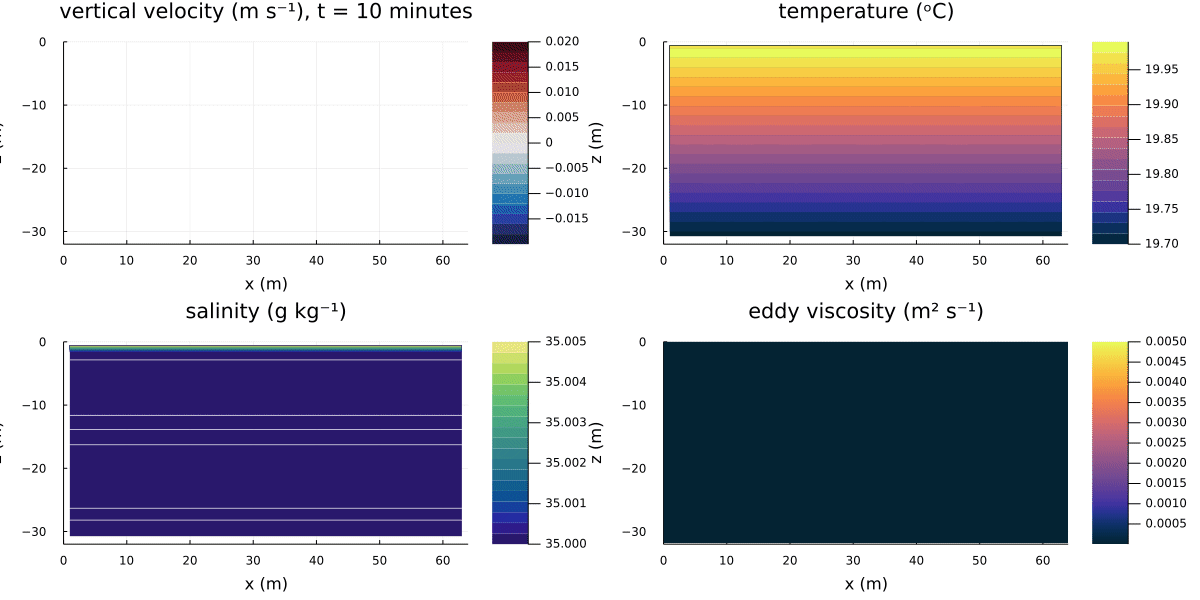

In [47]:
gif(anim,"Convection_turbulation.gif",fps=10)

In [26]:
size(W)

LoadError: UndefVarError: W not defined

In [37]:
yw

32-element view(OffsetArray(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, -2:35), 1:32) with eltype Float64:
  1.0
  3.0
  5.0
  7.0
  9.0
 11.0
 13.0
 15.0
 17.0
 19.0
 21.0
 23.0
 25.0
  ⋮
 41.0
 43.0
 45.0
 47.0
 49.0
 51.0
 53.0
 55.0
 57.0
 59.0
 61.0
 63.0

In [43]:
it=1
w1 = file["timeseries/w/$it"]

LoadError: KeyError: key "1" not found